# Soft Attention MNIST

This is jupyter notebook for `Soft Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
<br>This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). <br>This modified MNIST dataset is good for verifying attention algorithm.
<br>You can download modified MNIST data from this link
<br>[Training dataset](https://www.dropbox.com/s/e7jxyulxx2anqyq/MNIST_data_train_re.mat?dl=0)  /  [Testing dataset](https://www.dropbox.com/s/fcw4754bavva9my/MNIST_data_test_re.mat?dl=0)

# TENSORFLOW 1

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform
import cv2
import os

/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
print(tf.version.VERSION)

1.14.0


In [3]:
print(tf.test.is_gpu_available())

False


In [4]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
((train_x, train_y), (test_x, test_y)) = cifar10.load_data()

train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

print(train_x[0].shape, train_y.shape)
# train_x = np.expand_dims(train_x, axis=3)
# test_x = np.expand_dims(test_x, axis=3)
# print(train_x.shape, train_y.shape)

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
print(np.max(test_x), np.min(test_x))

input_shape = train_x[0].shape
output_shape = train_y[0].shape[0]
print(input_shape, output_shape)

IMG_SIZE, CHANNELS = input_shape[0], input_shape[2]
print(IMG_SIZE, CHANNELS)

(32, 32, 3) (50000, 10)
Train data shape: (50000, 32, 32, 3)
Train label shape: (50000, 10)
Test data shape: (10000, 32, 32, 3)
Test label shape: (10000, 10)
1.0 0.0
(32, 32, 3) 10
32 3


## Parameters

In [5]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_path = 'saved_models/cifrar_soft/'
if not os.path.exists(save_path):
  os.makedirs(save_path)

# Numbers of sampling to test the code 
num_test_sample = 50

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

## Plotting Sample Image (Modified MNIST for Attention)

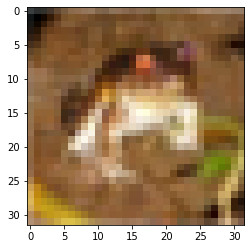

Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Shape: 32x32


In [6]:
# Plotting example image
img = train_x[0, :, :]

plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))
print('Shape: ' + str(img_size) + 'x' + str(img_size))

## Functions for Convolutional Network

In [7]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [8]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Soft Attention function
def soft_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)     
    alpha = tf.nn.softmax(m_concat) 
    z_list = [tf.multiply(a[i], tf.slice(alpha, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)

    return alpha, z
    

## Network

In [9]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_size, img_size, CHANNELS])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

# Convolution variables
w_conv1 = weight_variable('W_conv1', [3, 3, CHANNELS, 64])
b_conv1 = bias_variable('b_conv1', [64])
w_conv2 = weight_variable('W_conv2', [3, 3, 64, 256])
b_conv2 = bias_variable('b_conv2', [256])
w_conv3 = weight_variable('W_conv3', [3, 3, 256, 512])
b_conv3 = bias_variable('b_conv3', [512])

conv1 = tf.nn.relu(conv2d(x_image, w_conv1, 2) + b_conv1)
conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 2) + b_conv2)
conv3 = tf.nn.relu(conv2d(conv2, w_conv3, 2) + b_conv3)

conv_size = conv3.get_shape()[1]
conv_flat = tf.reshape(conv3, [-1, conv_size*conv_size, 512])
conv_unstack = tf.unstack(conv_flat, axis = 1)

#LSTM Variables
Wf = weight_variable('Wf', [512 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [512 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [512 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [512 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [512, 1])
Wh = weight_variable('Wh', [lstm_size, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha, z = soft_attention(rnn_out, conv_unstack, Wa, Wh)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [10]:
# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Create Session

In [11]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [12]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state(save_path)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

## Training

In [15]:
# Training
interval_test=num_epoch/2
if Is_train == True:
    train_data_num = train_x.shape[0]
    test_data_num = test_x.shape[0]
    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]

            # Make image as fractions for attention
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, CHANNELS))
            #validation_batch = np.reshape(validation_x, (validation_x.shape[0], img_size, img_size, 1))
            
            # Training
            optimizer.run(feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            #val_acc = sess.run(accuracy, feed_dict = {x_image: validation_batch, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc))# + ' / ' + 
#                   "Validation Accuracy: " + str(val_acc))  

        if (i+1)%interval_test==0:
            num_correct = 0
            saver.save(sess, save_path + "soft_attention")
            print('Model is saved!!!')

            print('Testing ...')
            idx = random.sample(range(test_x.shape[0]), test_data_num)
            for idx_sample in range(test_data_num):
                test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,CHANNELS]))
                test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
                output_ = sess.run(output,feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
                
                y_test_pred = np.argmax(output_[:])
                y_test_true = np.argmax(test_y[idx[idx_sample], :])
                if y_test_pred == y_test_true:
                    num_correct += 1.
                
            # Print Progress
            print("Testing Accuracy: " + str(num_correct/test_data_num))# + ' / ' + )

Epoch: 1 / Batch: 0/50000 / Cost: 0.2203925 / Training Accuracy: 0.48046875
Epoch: 1 / Batch: 256/50000 / Cost: 0.23388176 / Training Accuracy: 0.4609375
Epoch: 1 / Batch: 512/50000 / Cost: 0.22867832 / Training Accuracy: 0.46875
Epoch: 1 / Batch: 768/50000 / Cost: 0.22002561 / Training Accuracy: 0.47265625
Epoch: 1 / Batch: 1024/50000 / Cost: 0.22049312 / Training Accuracy: 0.51171875
Epoch: 1 / Batch: 1280/50000 / Cost: 0.21630368 / Training Accuracy: 0.49609375
Epoch: 1 / Batch: 1536/50000 / Cost: 0.22444245 / Training Accuracy: 0.48046875
Epoch: 1 / Batch: 1792/50000 / Cost: 0.2182746 / Training Accuracy: 0.48828125
Epoch: 1 / Batch: 2048/50000 / Cost: 0.21431193 / Training Accuracy: 0.51953125
Epoch: 1 / Batch: 2304/50000 / Cost: 0.21452045 / Training Accuracy: 0.48046875
Epoch: 1 / Batch: 2560/50000 / Cost: 0.2186723 / Training Accuracy: 0.5
Epoch: 1 / Batch: 2816/50000 / Cost: 0.22088584 / Training Accuracy: 0.46875
Epoch: 1 / Batch: 3072/50000 / Cost: 0.20857319 / Training Accu

Epoch: 1 / Batch: 26624/50000 / Cost: 0.21130571 / Training Accuracy: 0.53125
Epoch: 1 / Batch: 26880/50000 / Cost: 0.21104825 / Training Accuracy: 0.515625
Epoch: 1 / Batch: 27136/50000 / Cost: 0.21237841 / Training Accuracy: 0.546875
Epoch: 1 / Batch: 27392/50000 / Cost: 0.21584544 / Training Accuracy: 0.4609375
Epoch: 1 / Batch: 27648/50000 / Cost: 0.21529326 / Training Accuracy: 0.48046875
Epoch: 1 / Batch: 27904/50000 / Cost: 0.21837583 / Training Accuracy: 0.48828125
Epoch: 1 / Batch: 28160/50000 / Cost: 0.21448307 / Training Accuracy: 0.51953125
Epoch: 1 / Batch: 28416/50000 / Cost: 0.20269287 / Training Accuracy: 0.55859375
Epoch: 1 / Batch: 28672/50000 / Cost: 0.19857696 / Training Accuracy: 0.5625
Epoch: 1 / Batch: 28928/50000 / Cost: 0.21554878 / Training Accuracy: 0.48828125
Epoch: 1 / Batch: 29184/50000 / Cost: 0.22259417 / Training Accuracy: 0.44140625
Epoch: 1 / Batch: 29440/50000 / Cost: 0.22211614 / Training Accuracy: 0.48046875
Epoch: 1 / Batch: 29696/50000 / Cost: 0.

Epoch: 2 / Batch: 2816/50000 / Cost: 0.21867199 / Training Accuracy: 0.484375
Epoch: 2 / Batch: 3072/50000 / Cost: 0.21284437 / Training Accuracy: 0.50390625
Epoch: 2 / Batch: 3328/50000 / Cost: 0.2078336 / Training Accuracy: 0.51953125
Epoch: 2 / Batch: 3584/50000 / Cost: 0.21342418 / Training Accuracy: 0.5234375
Epoch: 2 / Batch: 3840/50000 / Cost: 0.20794766 / Training Accuracy: 0.53515625
Epoch: 2 / Batch: 4096/50000 / Cost: 0.19842616 / Training Accuracy: 0.546875
Epoch: 2 / Batch: 4352/50000 / Cost: 0.19827206 / Training Accuracy: 0.5625
Epoch: 2 / Batch: 4608/50000 / Cost: 0.20399246 / Training Accuracy: 0.53515625
Epoch: 2 / Batch: 4864/50000 / Cost: 0.20305434 / Training Accuracy: 0.5390625
Epoch: 2 / Batch: 5120/50000 / Cost: 0.20929757 / Training Accuracy: 0.52734375
Epoch: 2 / Batch: 5376/50000 / Cost: 0.20353656 / Training Accuracy: 0.5
Epoch: 2 / Batch: 5632/50000 / Cost: 0.22244123 / Training Accuracy: 0.48046875
Epoch: 2 / Batch: 5888/50000 / Cost: 0.22356324 / Training

Epoch: 2 / Batch: 29440/50000 / Cost: 0.217428 / Training Accuracy: 0.47265625
Epoch: 2 / Batch: 29696/50000 / Cost: 0.22569776 / Training Accuracy: 0.46484375
Epoch: 2 / Batch: 29952/50000 / Cost: 0.20456347 / Training Accuracy: 0.546875
Epoch: 2 / Batch: 30208/50000 / Cost: 0.21181917 / Training Accuracy: 0.4765625
Epoch: 2 / Batch: 30464/50000 / Cost: 0.21474436 / Training Accuracy: 0.4609375
Epoch: 2 / Batch: 30720/50000 / Cost: 0.18995908 / Training Accuracy: 0.53515625
Epoch: 2 / Batch: 30976/50000 / Cost: 0.20001602 / Training Accuracy: 0.5703125
Epoch: 2 / Batch: 31232/50000 / Cost: 0.19430575 / Training Accuracy: 0.55078125
Epoch: 2 / Batch: 31488/50000 / Cost: 0.20945004 / Training Accuracy: 0.51953125
Epoch: 2 / Batch: 31744/50000 / Cost: 0.2013472 / Training Accuracy: 0.55078125
Epoch: 2 / Batch: 32000/50000 / Cost: 0.21258679 / Training Accuracy: 0.515625
Epoch: 2 / Batch: 32256/50000 / Cost: 0.19804308 / Training Accuracy: 0.5625
Epoch: 2 / Batch: 32512/50000 / Cost: 0.19

Epoch: 3 / Batch: 5888/50000 / Cost: 0.20617647 / Training Accuracy: 0.48828125
Epoch: 3 / Batch: 6144/50000 / Cost: 0.19426453 / Training Accuracy: 0.56640625
Epoch: 3 / Batch: 6400/50000 / Cost: 0.20471224 / Training Accuracy: 0.515625
Epoch: 3 / Batch: 6656/50000 / Cost: 0.19207421 / Training Accuracy: 0.546875
Epoch: 3 / Batch: 6912/50000 / Cost: 0.19913746 / Training Accuracy: 0.5390625
Epoch: 3 / Batch: 7168/50000 / Cost: 0.19998765 / Training Accuracy: 0.515625
Epoch: 3 / Batch: 7424/50000 / Cost: 0.20533371 / Training Accuracy: 0.51953125
Epoch: 3 / Batch: 7680/50000 / Cost: 0.19738095 / Training Accuracy: 0.5546875
Epoch: 3 / Batch: 7936/50000 / Cost: 0.21924326 / Training Accuracy: 0.48828125
Epoch: 3 / Batch: 8192/50000 / Cost: 0.19747162 / Training Accuracy: 0.546875
Epoch: 3 / Batch: 8448/50000 / Cost: 0.19860566 / Training Accuracy: 0.5546875
Epoch: 3 / Batch: 8704/50000 / Cost: 0.18748704 / Training Accuracy: 0.53515625
Epoch: 3 / Batch: 8960/50000 / Cost: 0.19708739 / T

Epoch: 3 / Batch: 32256/50000 / Cost: 0.20661084 / Training Accuracy: 0.4921875
Epoch: 3 / Batch: 32512/50000 / Cost: 0.18299994 / Training Accuracy: 0.57421875
Epoch: 3 / Batch: 32768/50000 / Cost: 0.20290415 / Training Accuracy: 0.52734375
Epoch: 3 / Batch: 33024/50000 / Cost: 0.21782127 / Training Accuracy: 0.48828125
Epoch: 3 / Batch: 33280/50000 / Cost: 0.21520725 / Training Accuracy: 0.515625
Epoch: 3 / Batch: 33536/50000 / Cost: 0.20236155 / Training Accuracy: 0.50390625
Epoch: 3 / Batch: 33792/50000 / Cost: 0.19262946 / Training Accuracy: 0.5546875
Epoch: 3 / Batch: 34048/50000 / Cost: 0.22202098 / Training Accuracy: 0.49609375
Epoch: 3 / Batch: 34304/50000 / Cost: 0.20098118 / Training Accuracy: 0.53125
Epoch: 3 / Batch: 34560/50000 / Cost: 0.20538346 / Training Accuracy: 0.55859375
Epoch: 3 / Batch: 34816/50000 / Cost: 0.20057864 / Training Accuracy: 0.5546875
Epoch: 3 / Batch: 35072/50000 / Cost: 0.209584 / Training Accuracy: 0.51953125
Epoch: 3 / Batch: 35328/50000 / Cost: 

Epoch: 4 / Batch: 8704/50000 / Cost: 0.19472945 / Training Accuracy: 0.53515625
Epoch: 4 / Batch: 8960/50000 / Cost: 0.19105999 / Training Accuracy: 0.58203125
Epoch: 4 / Batch: 9216/50000 / Cost: 0.1967186 / Training Accuracy: 0.57421875
Epoch: 4 / Batch: 9472/50000 / Cost: 0.1959413 / Training Accuracy: 0.578125
Epoch: 4 / Batch: 9728/50000 / Cost: 0.19667366 / Training Accuracy: 0.546875
Epoch: 4 / Batch: 9984/50000 / Cost: 0.1944629 / Training Accuracy: 0.55859375
Epoch: 4 / Batch: 10240/50000 / Cost: 0.2015758 / Training Accuracy: 0.53125
Epoch: 4 / Batch: 10496/50000 / Cost: 0.18938157 / Training Accuracy: 0.58984375
Epoch: 4 / Batch: 10752/50000 / Cost: 0.20469026 / Training Accuracy: 0.50390625
Epoch: 4 / Batch: 11008/50000 / Cost: 0.19994298 / Training Accuracy: 0.55859375
Epoch: 4 / Batch: 11264/50000 / Cost: 0.17759283 / Training Accuracy: 0.62890625
Epoch: 4 / Batch: 11520/50000 / Cost: 0.19038293 / Training Accuracy: 0.56640625
Epoch: 4 / Batch: 11776/50000 / Cost: 0.19266

Epoch: 4 / Batch: 35072/50000 / Cost: 0.18949121 / Training Accuracy: 0.5625
Epoch: 4 / Batch: 35328/50000 / Cost: 0.18495397 / Training Accuracy: 0.5703125
Epoch: 4 / Batch: 35584/50000 / Cost: 0.1880054 / Training Accuracy: 0.578125
Epoch: 4 / Batch: 35840/50000 / Cost: 0.19787408 / Training Accuracy: 0.53125
Epoch: 4 / Batch: 36096/50000 / Cost: 0.18965416 / Training Accuracy: 0.56640625
Epoch: 4 / Batch: 36352/50000 / Cost: 0.19219698 / Training Accuracy: 0.54296875
Epoch: 4 / Batch: 36608/50000 / Cost: 0.19230403 / Training Accuracy: 0.54296875
Epoch: 4 / Batch: 36864/50000 / Cost: 0.18659839 / Training Accuracy: 0.5703125
Epoch: 4 / Batch: 37120/50000 / Cost: 0.19723985 / Training Accuracy: 0.53515625
Epoch: 4 / Batch: 37376/50000 / Cost: 0.2024881 / Training Accuracy: 0.5234375
Epoch: 4 / Batch: 37632/50000 / Cost: 0.1964412 / Training Accuracy: 0.55859375
Epoch: 4 / Batch: 37888/50000 / Cost: 0.19981806 / Training Accuracy: 0.52734375
Epoch: 4 / Batch: 38144/50000 / Cost: 0.188

Epoch: 5 / Batch: 11520/50000 / Cost: 0.19041899 / Training Accuracy: 0.5859375
Epoch: 5 / Batch: 11776/50000 / Cost: 0.179412 / Training Accuracy: 0.6171875
Epoch: 5 / Batch: 12032/50000 / Cost: 0.19804098 / Training Accuracy: 0.55078125
Epoch: 5 / Batch: 12288/50000 / Cost: 0.18068258 / Training Accuracy: 0.5859375
Epoch: 5 / Batch: 12544/50000 / Cost: 0.18238238 / Training Accuracy: 0.61328125
Epoch: 5 / Batch: 12800/50000 / Cost: 0.18433447 / Training Accuracy: 0.55078125
Epoch: 5 / Batch: 13056/50000 / Cost: 0.17761093 / Training Accuracy: 0.6171875
Epoch: 5 / Batch: 13312/50000 / Cost: 0.18245403 / Training Accuracy: 0.6015625
Epoch: 5 / Batch: 13568/50000 / Cost: 0.19038318 / Training Accuracy: 0.56640625
Epoch: 5 / Batch: 13824/50000 / Cost: 0.18742032 / Training Accuracy: 0.58984375
Epoch: 5 / Batch: 14080/50000 / Cost: 0.1817188 / Training Accuracy: 0.5546875
Epoch: 5 / Batch: 14336/50000 / Cost: 0.1862038 / Training Accuracy: 0.58203125
Epoch: 5 / Batch: 14592/50000 / Cost: 

Epoch: 5 / Batch: 37888/50000 / Cost: 0.1844466 / Training Accuracy: 0.5859375
Epoch: 5 / Batch: 38144/50000 / Cost: 0.18706843 / Training Accuracy: 0.57421875
Epoch: 5 / Batch: 38400/50000 / Cost: 0.17823517 / Training Accuracy: 0.58984375
Epoch: 5 / Batch: 38656/50000 / Cost: 0.2016331 / Training Accuracy: 0.55859375
Epoch: 5 / Batch: 38912/50000 / Cost: 0.18858655 / Training Accuracy: 0.55859375
Epoch: 5 / Batch: 39168/50000 / Cost: 0.18455134 / Training Accuracy: 0.6015625
Epoch: 5 / Batch: 39424/50000 / Cost: 0.1929294 / Training Accuracy: 0.578125
Epoch: 5 / Batch: 39680/50000 / Cost: 0.18464702 / Training Accuracy: 0.5859375
Epoch: 5 / Batch: 39936/50000 / Cost: 0.19739136 / Training Accuracy: 0.53515625
Epoch: 5 / Batch: 40192/50000 / Cost: 0.18361907 / Training Accuracy: 0.6015625
Epoch: 5 / Batch: 40448/50000 / Cost: 0.1898615 / Training Accuracy: 0.5390625
Epoch: 5 / Batch: 40704/50000 / Cost: 0.1791343 / Training Accuracy: 0.5546875
Epoch: 5 / Batch: 40960/50000 / Cost: 0.1

Epoch: 6 / Batch: 14080/50000 / Cost: 0.17703745 / Training Accuracy: 0.609375
Epoch: 6 / Batch: 14336/50000 / Cost: 0.18422475 / Training Accuracy: 0.59765625
Epoch: 6 / Batch: 14592/50000 / Cost: 0.19325362 / Training Accuracy: 0.5546875
Epoch: 6 / Batch: 14848/50000 / Cost: 0.17693564 / Training Accuracy: 0.625
Epoch: 6 / Batch: 15104/50000 / Cost: 0.17530066 / Training Accuracy: 0.625
Epoch: 6 / Batch: 15360/50000 / Cost: 0.17190845 / Training Accuracy: 0.63671875
Epoch: 6 / Batch: 15616/50000 / Cost: 0.18609068 / Training Accuracy: 0.53515625
Epoch: 6 / Batch: 15872/50000 / Cost: 0.18635254 / Training Accuracy: 0.546875
Epoch: 6 / Batch: 16128/50000 / Cost: 0.19261834 / Training Accuracy: 0.578125
Epoch: 6 / Batch: 16384/50000 / Cost: 0.1676065 / Training Accuracy: 0.609375
Epoch: 6 / Batch: 16640/50000 / Cost: 0.18025306 / Training Accuracy: 0.58984375
Epoch: 6 / Batch: 16896/50000 / Cost: 0.18036653 / Training Accuracy: 0.5859375
Epoch: 6 / Batch: 17152/50000 / Cost: 0.1845403 /

Epoch: 6 / Batch: 40448/50000 / Cost: 0.17800193 / Training Accuracy: 0.609375
Epoch: 6 / Batch: 40704/50000 / Cost: 0.17111044 / Training Accuracy: 0.6171875
Epoch: 6 / Batch: 40960/50000 / Cost: 0.18702525 / Training Accuracy: 0.578125
Epoch: 6 / Batch: 41216/50000 / Cost: 0.18354578 / Training Accuracy: 0.57421875
Epoch: 6 / Batch: 41472/50000 / Cost: 0.1757315 / Training Accuracy: 0.58984375
Epoch: 6 / Batch: 41728/50000 / Cost: 0.19093515 / Training Accuracy: 0.5703125
Epoch: 6 / Batch: 41984/50000 / Cost: 0.16855781 / Training Accuracy: 0.625
Epoch: 6 / Batch: 42240/50000 / Cost: 0.19344942 / Training Accuracy: 0.55859375
Epoch: 6 / Batch: 42496/50000 / Cost: 0.16481344 / Training Accuracy: 0.671875
Epoch: 6 / Batch: 42752/50000 / Cost: 0.17466788 / Training Accuracy: 0.58203125
Epoch: 6 / Batch: 43008/50000 / Cost: 0.18657109 / Training Accuracy: 0.62109375
Epoch: 6 / Batch: 43264/50000 / Cost: 0.17848845 / Training Accuracy: 0.58984375
Epoch: 6 / Batch: 43520/50000 / Cost: 0.17

Epoch: 7 / Batch: 16896/50000 / Cost: 0.1795178 / Training Accuracy: 0.6328125
Epoch: 7 / Batch: 17152/50000 / Cost: 0.16601011 / Training Accuracy: 0.63671875
Epoch: 7 / Batch: 17408/50000 / Cost: 0.1921316 / Training Accuracy: 0.56640625
Epoch: 7 / Batch: 17664/50000 / Cost: 0.20466611 / Training Accuracy: 0.53515625
Epoch: 7 / Batch: 17920/50000 / Cost: 0.17127018 / Training Accuracy: 0.6328125
Epoch: 7 / Batch: 18176/50000 / Cost: 0.17941925 / Training Accuracy: 0.5859375
Epoch: 7 / Batch: 18432/50000 / Cost: 0.1804289 / Training Accuracy: 0.61328125
Epoch: 7 / Batch: 18688/50000 / Cost: 0.18557039 / Training Accuracy: 0.57421875
Epoch: 7 / Batch: 18944/50000 / Cost: 0.17605901 / Training Accuracy: 0.62109375
Epoch: 7 / Batch: 19200/50000 / Cost: 0.17173128 / Training Accuracy: 0.6328125
Epoch: 7 / Batch: 19456/50000 / Cost: 0.1703969 / Training Accuracy: 0.58203125
Epoch: 7 / Batch: 19712/50000 / Cost: 0.18261592 / Training Accuracy: 0.61328125
Epoch: 7 / Batch: 19968/50000 / Cost

Epoch: 7 / Batch: 43264/50000 / Cost: 0.18376502 / Training Accuracy: 0.58984375
Epoch: 7 / Batch: 43520/50000 / Cost: 0.17666143 / Training Accuracy: 0.59765625
Epoch: 7 / Batch: 43776/50000 / Cost: 0.16591926 / Training Accuracy: 0.66015625
Epoch: 7 / Batch: 44032/50000 / Cost: 0.16729578 / Training Accuracy: 0.64453125
Epoch: 7 / Batch: 44288/50000 / Cost: 0.17694569 / Training Accuracy: 0.609375
Epoch: 7 / Batch: 44544/50000 / Cost: 0.16665363 / Training Accuracy: 0.640625
Epoch: 7 / Batch: 44800/50000 / Cost: 0.16912958 / Training Accuracy: 0.6328125
Epoch: 7 / Batch: 45056/50000 / Cost: 0.17543997 / Training Accuracy: 0.6015625
Epoch: 7 / Batch: 45312/50000 / Cost: 0.18289948 / Training Accuracy: 0.56640625
Epoch: 7 / Batch: 45568/50000 / Cost: 0.18512434 / Training Accuracy: 0.60546875
Epoch: 7 / Batch: 45824/50000 / Cost: 0.16097109 / Training Accuracy: 0.66796875
Epoch: 7 / Batch: 46080/50000 / Cost: 0.17671224 / Training Accuracy: 0.58984375
Epoch: 7 / Batch: 46336/50000 / Co

Epoch: 8 / Batch: 19456/50000 / Cost: 0.17058113 / Training Accuracy: 0.61328125
Epoch: 8 / Batch: 19712/50000 / Cost: 0.16154888 / Training Accuracy: 0.67578125
Epoch: 8 / Batch: 19968/50000 / Cost: 0.15719506 / Training Accuracy: 0.625
Epoch: 8 / Batch: 20224/50000 / Cost: 0.16514616 / Training Accuracy: 0.6640625
Epoch: 8 / Batch: 20480/50000 / Cost: 0.172702 / Training Accuracy: 0.58203125
Epoch: 8 / Batch: 20736/50000 / Cost: 0.15239282 / Training Accuracy: 0.69921875
Epoch: 8 / Batch: 20992/50000 / Cost: 0.16547005 / Training Accuracy: 0.6640625
Epoch: 8 / Batch: 21248/50000 / Cost: 0.14941123 / Training Accuracy: 0.6875
Epoch: 8 / Batch: 21504/50000 / Cost: 0.17340095 / Training Accuracy: 0.6171875
Epoch: 8 / Batch: 21760/50000 / Cost: 0.15483114 / Training Accuracy: 0.65625
Epoch: 8 / Batch: 22016/50000 / Cost: 0.17454025 / Training Accuracy: 0.64453125
Epoch: 8 / Batch: 22272/50000 / Cost: 0.17789307 / Training Accuracy: 0.61328125
Epoch: 8 / Batch: 22528/50000 / Cost: 0.15378

Epoch: 8 / Batch: 45824/50000 / Cost: 0.1894489 / Training Accuracy: 0.5859375
Epoch: 8 / Batch: 46080/50000 / Cost: 0.1564397 / Training Accuracy: 0.671875
Epoch: 8 / Batch: 46336/50000 / Cost: 0.15853313 / Training Accuracy: 0.65625
Epoch: 8 / Batch: 46592/50000 / Cost: 0.18011756 / Training Accuracy: 0.58203125
Epoch: 8 / Batch: 46848/50000 / Cost: 0.1624747 / Training Accuracy: 0.67578125
Epoch: 8 / Batch: 47104/50000 / Cost: 0.1648498 / Training Accuracy: 0.609375
Epoch: 8 / Batch: 47360/50000 / Cost: 0.1705565 / Training Accuracy: 0.6015625
Epoch: 8 / Batch: 47616/50000 / Cost: 0.16765912 / Training Accuracy: 0.59765625
Epoch: 8 / Batch: 47872/50000 / Cost: 0.15755817 / Training Accuracy: 0.68359375
Epoch: 8 / Batch: 48128/50000 / Cost: 0.19417079 / Training Accuracy: 0.5703125
Epoch: 8 / Batch: 48384/50000 / Cost: 0.17484447 / Training Accuracy: 0.6171875
Epoch: 8 / Batch: 48640/50000 / Cost: 0.16752668 / Training Accuracy: 0.64453125
Epoch: 8 / Batch: 48896/50000 / Cost: 0.1651

Epoch: 9 / Batch: 22272/50000 / Cost: 0.16022167 / Training Accuracy: 0.62109375
Epoch: 9 / Batch: 22528/50000 / Cost: 0.16282105 / Training Accuracy: 0.6484375
Epoch: 9 / Batch: 22784/50000 / Cost: 0.16946474 / Training Accuracy: 0.6171875
Epoch: 9 / Batch: 23040/50000 / Cost: 0.14204805 / Training Accuracy: 0.71875
Epoch: 9 / Batch: 23296/50000 / Cost: 0.16168974 / Training Accuracy: 0.64453125
Epoch: 9 / Batch: 23552/50000 / Cost: 0.15107684 / Training Accuracy: 0.67578125
Epoch: 9 / Batch: 23808/50000 / Cost: 0.16656695 / Training Accuracy: 0.6171875
Epoch: 9 / Batch: 24064/50000 / Cost: 0.16207106 / Training Accuracy: 0.65234375
Epoch: 9 / Batch: 24320/50000 / Cost: 0.16187043 / Training Accuracy: 0.640625
Epoch: 9 / Batch: 24576/50000 / Cost: 0.1602081 / Training Accuracy: 0.625
Epoch: 9 / Batch: 24832/50000 / Cost: 0.15869531 / Training Accuracy: 0.65625
Epoch: 9 / Batch: 25088/50000 / Cost: 0.14858362 / Training Accuracy: 0.703125
Epoch: 9 / Batch: 25344/50000 / Cost: 0.1600901

Epoch: 9 / Batch: 48640/50000 / Cost: 0.16132104 / Training Accuracy: 0.6484375
Epoch: 9 / Batch: 48896/50000 / Cost: 0.16240978 / Training Accuracy: 0.65234375
Epoch: 9 / Batch: 49152/50000 / Cost: 0.15888079 / Training Accuracy: 0.6328125
Epoch: 9 / Batch: 49408/50000 / Cost: 0.15014575 / Training Accuracy: 0.68359375
Epoch: 9 / Batch: 49664/50000 / Cost: 0.15534301 / Training Accuracy: 0.67578125
Epoch: 9 / Batch: 49920/50000 / Cost: 0.17146008 / Training Accuracy: 0.6125
Epoch: 10 / Batch: 0/50000 / Cost: 0.14854975 / Training Accuracy: 0.703125
Epoch: 10 / Batch: 256/50000 / Cost: 0.15096036 / Training Accuracy: 0.69140625
Epoch: 10 / Batch: 512/50000 / Cost: 0.15631637 / Training Accuracy: 0.6328125
Epoch: 10 / Batch: 768/50000 / Cost: 0.14584282 / Training Accuracy: 0.69921875
Epoch: 10 / Batch: 1024/50000 / Cost: 0.15842178 / Training Accuracy: 0.625
Epoch: 10 / Batch: 1280/50000 / Cost: 0.16121693 / Training Accuracy: 0.6484375
Epoch: 10 / Batch: 1536/50000 / Cost: 0.17361891 

Epoch: 10 / Batch: 24832/50000 / Cost: 0.16329095 / Training Accuracy: 0.65234375
Epoch: 10 / Batch: 25088/50000 / Cost: 0.16579568 / Training Accuracy: 0.62890625
Epoch: 10 / Batch: 25344/50000 / Cost: 0.15648171 / Training Accuracy: 0.66796875
Epoch: 10 / Batch: 25600/50000 / Cost: 0.15415946 / Training Accuracy: 0.6796875
Epoch: 10 / Batch: 25856/50000 / Cost: 0.16199198 / Training Accuracy: 0.6328125
Epoch: 10 / Batch: 26112/50000 / Cost: 0.15774664 / Training Accuracy: 0.66796875
Epoch: 10 / Batch: 26368/50000 / Cost: 0.15133503 / Training Accuracy: 0.67578125
Epoch: 10 / Batch: 26624/50000 / Cost: 0.14043923 / Training Accuracy: 0.6953125
Epoch: 10 / Batch: 26880/50000 / Cost: 0.14473602 / Training Accuracy: 0.6953125
Epoch: 10 / Batch: 27136/50000 / Cost: 0.14679313 / Training Accuracy: 0.67578125
Epoch: 10 / Batch: 27392/50000 / Cost: 0.14940622 / Training Accuracy: 0.671875
Epoch: 10 / Batch: 27648/50000 / Cost: 0.17073993 / Training Accuracy: 0.6171875
Epoch: 10 / Batch: 2790

## Testing

/home/jenazads/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


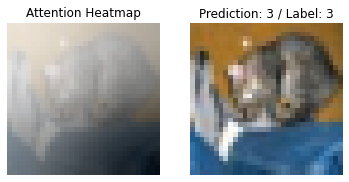

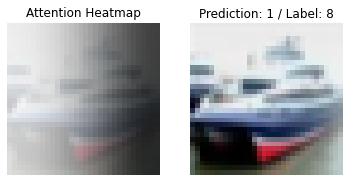

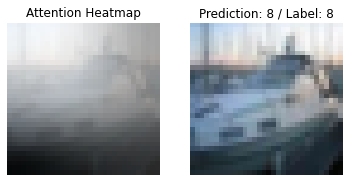

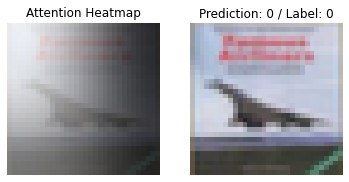

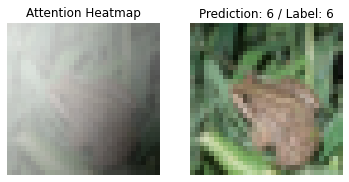

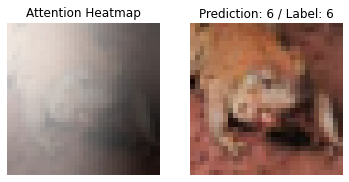

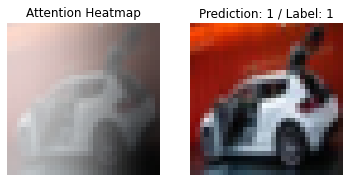

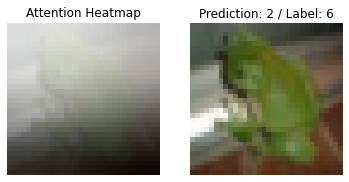

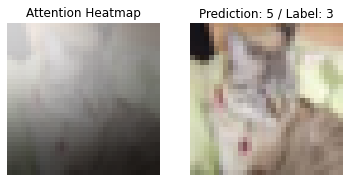

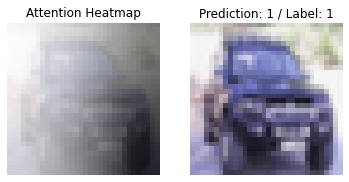

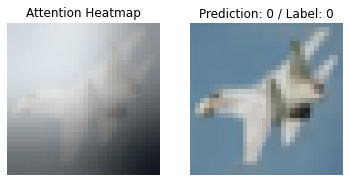

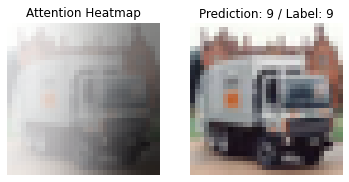

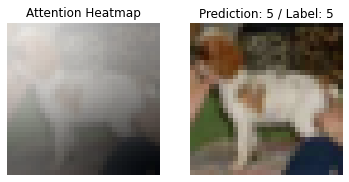

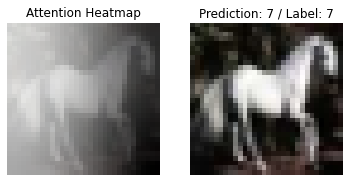

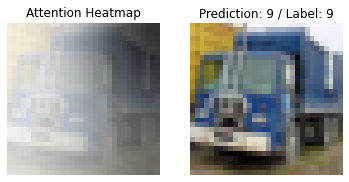

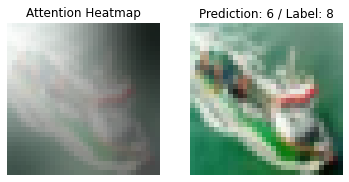

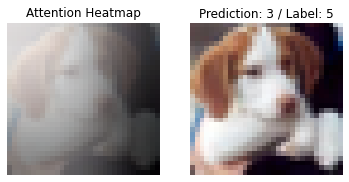

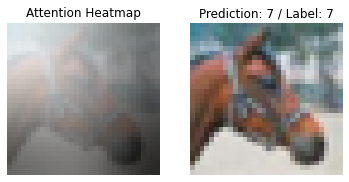

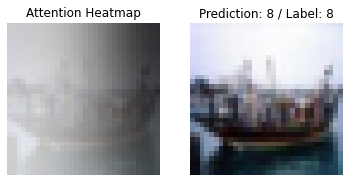

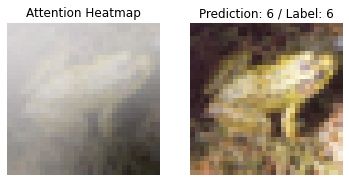

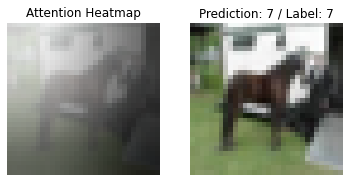

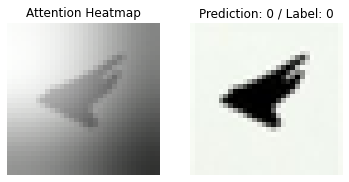

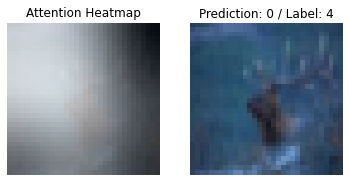

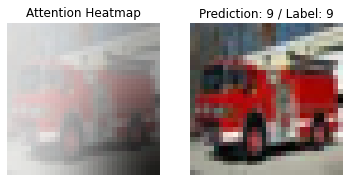

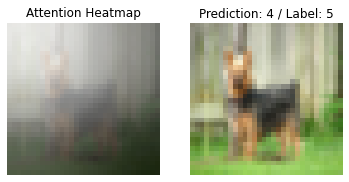

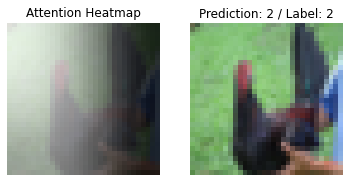

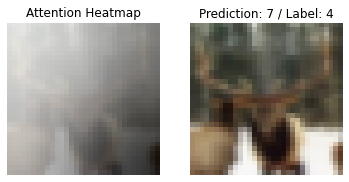

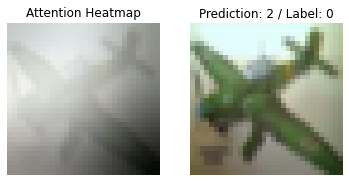

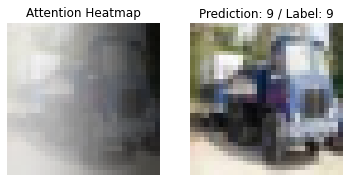

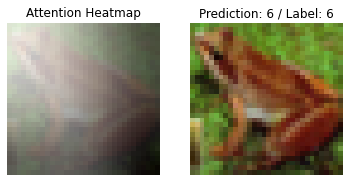

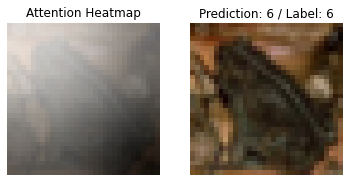

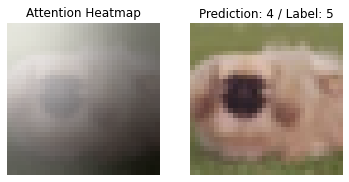

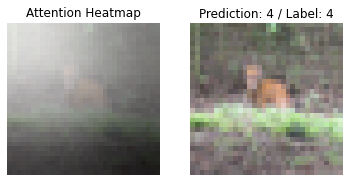

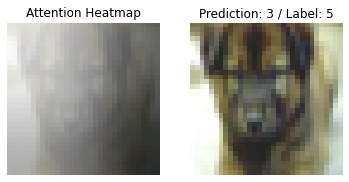

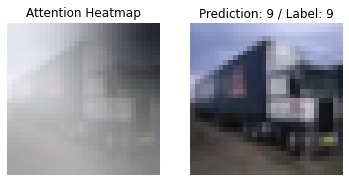

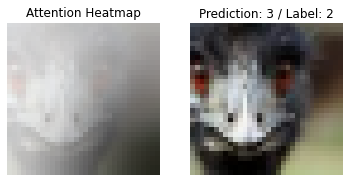

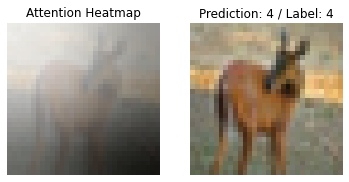

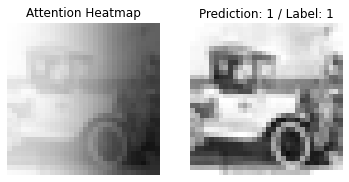

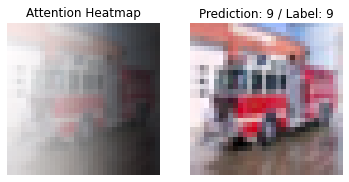

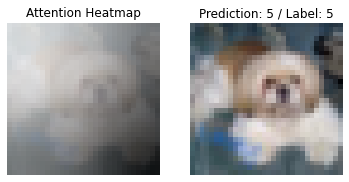

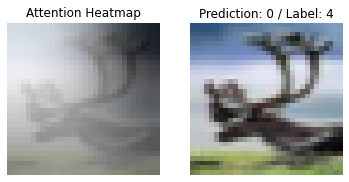

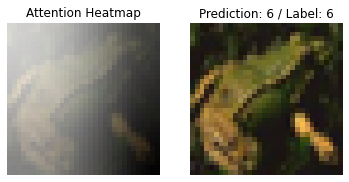

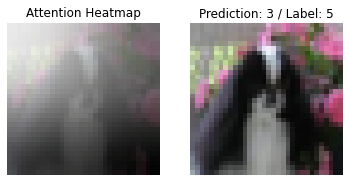

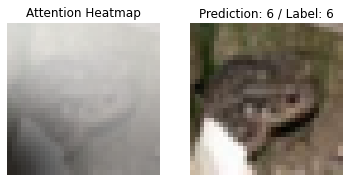

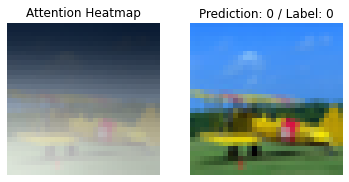

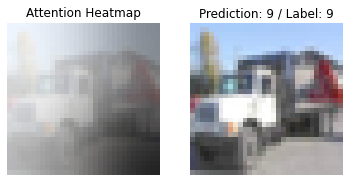

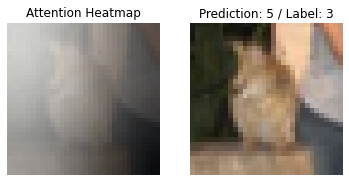

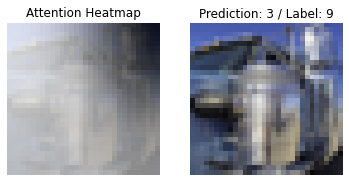

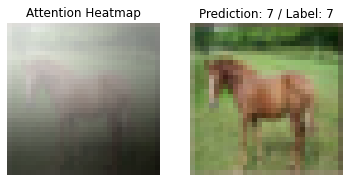

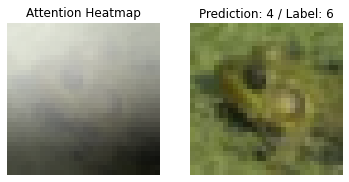

Sample Accuracy: 0.66


In [17]:
# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 1])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,CHANNELS]))
    test_x_in = test_x_reshape[idx_sample,:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx_sample,:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)
    alpha_resize = cv2.resize(alpha_resize, dsize=(img_size,img_size), interpolation=cv2.INTER_LINEAR)
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx_sample, :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(test_x[idx_sample,:,:], cmap='gray')
    i = ax[0].imshow(alpha_resize,cmap="gray", alpha=0.8)
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    
    ax[1].imshow(test_x[idx_sample,:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))